# Calculate Preformed vs Regenerated Carbon. 


In [78]:
%matplotlib inline

import xarray as xr
import intake

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [79]:
from dask.distributed import Client

client = Client("tcp://10.32.15.49:35117")
client

Client Scheduler: tcp://10.32.15.49:35117 Dashboard: /user/0000-0002-2993-7484/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [80]:
# Load collection

if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28657 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28657 zstore(s)

	> 59 dcpp_init_year(s)

In [81]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year'],
      dtype='object')

In [82]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [83]:
# grid variables (cf Jessica Luo)
model_grids={'CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn': 'ncells',
             'CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn': ['lon','lat'],
             'CMIP.BCC.BCC-ESM1.historical.Omon.gn': ['lon','lat'],
             'CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn': ['i','j'],
             'CMIP.CCCma.CanESM5.historical.Omon.gn': ['i','j'],
             'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn': ['x','y'], 
             'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn': ['x','y'],
             'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Omon.gn': ['i','j'],
             'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Omon.gn': ['i','j'],
             'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn': ['x','y'],
             'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn': ['x','y'],
             'CMIP.MIROC.MIROC6.historical.Omon.gn': ['x','y'],
             'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn': ['i','j'],
             'CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn': ['i','j'],
             'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn': ['x','y'],
             'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn': ['lon','lat'],
             'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Omon.gn': ['lon','lat'],
             'CMIP.NASA-GISS.GISS-E2-1-H.historical.Omon.gn': ['lon','lat'],
             'CMIP.NCAR.CESM2.historical.Omon.gn': ['nlon','nlat'],
             'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn': ['x','y'],
             'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn': ['x','y'],
             'CMIP.NUIST.NESM3.historical.Omon.gn': ['i','j'], 
             'CMIP.SNU.SAM0-UNICON.historical.Omon.gn': ['i','j'],
             'CMIP.UA.MCM-UA-1-0.historical.Omon.gn': ['longitude','latitude']}


In [84]:
cat = col.search(experiment_id='historical',
                 variable_id=['o2','o2sat','dissic'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':60, 'i':30, 'j':30}, 'decode_times': False})
model=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [85]:
cat = col.search(experiment_id='historical',
                 variable_id=['so'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':60, 'i':30, 'j':30}, 'decode_times': False})
models=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [86]:
cat = col.search(experiment_id='historical',
                 variable_id=['thetao'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':60, 'i':30, 'j':30}, 'decode_times': False})
modelt=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


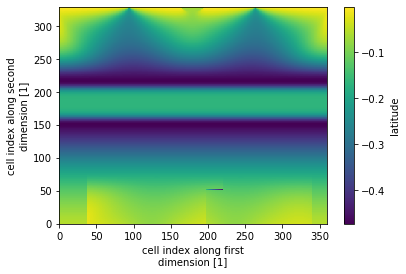

In [87]:
#Oh look, O2 is on a slightly different grid to T and S!!!!!
(model.latitude-modelt.latitude).plot()


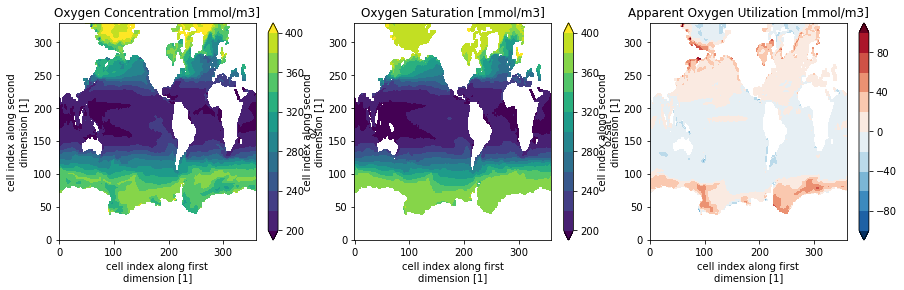

In [88]:
aou=(model.o2sat*1000-model.o2)

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,4),ncols=3,nrows=1)
(model.isel(time=-1).isel(lev=0).o2*1e3).plot(ax=ax1,levels=np.arange(200,420,20),extend="both")
# Looks like O2sat is 1000x too small! Maybe they doubley applied the mmol->mol conversion?
(model.isel(time=-1).isel(lev=0).o2sat*1e6).plot(ax=ax2,levels=np.arange(200,420,20),extend="both")
(aou.isel(time=-1).isel(lev=0)*1e3).plot(ax=ax3,levels=np.arange(-100,120,20),extend="both")

ax1.set_title("Oxygen Concentration [mmol/m3]")
ax2.set_title("Oxygen Saturation [mmol/m3]")
ax3.set_title("Apparent Oxygen Utilization [mmol/m3]")
plt.show()

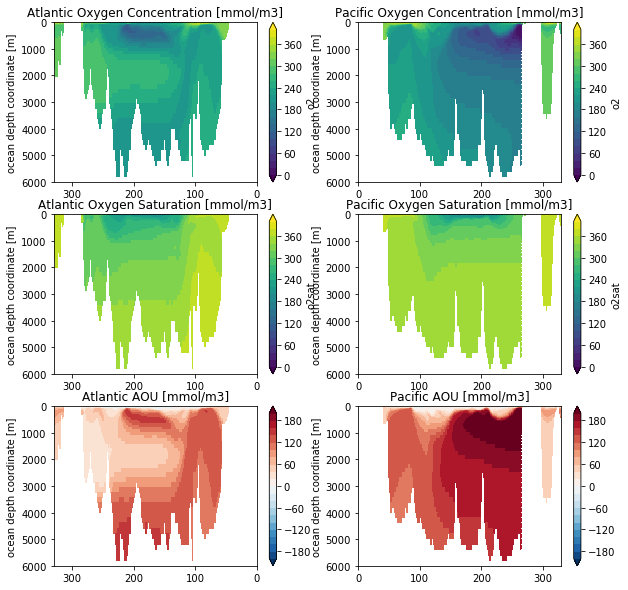

In [89]:
fig, (axes) = plt.subplots(figsize=(10,10),ncols=2,nrows=3)
(model.isel(time=-1).isel(i=255).o2*1e3).plot(ax=axes[0,0],levels=np.arange(0,420,20),extend="both")
(model.isel(time=-1).isel(i=125).o2*1e3).plot(ax=axes[0,1],levels=np.arange(0,420,20),extend="both")

# Looks like O2sat is 1000x too small! Maybe they doubley applied the mmol->mol conversion?
(model.isel(time=-1).isel(i=255).o2sat*1e6).plot(ax=axes[1,0],levels=np.arange(0,420,20),extend="both")
(model.isel(time=-1).isel(i=125).o2sat*1e6).plot(ax=axes[1,1],levels=np.arange(0,420,20),extend="both")

(aou.isel(time=-1).isel(i=255)*1e3).plot(ax=axes[2,0],levels=np.arange(-200,220,20),extend="both")
(aou.isel(time=-1).isel(i=125)*1e3).plot(ax=axes[2,1],levels=np.arange(-200,220,20),extend="both")

for jj in range(0,2):
    for ii in range(0,3):
        if jj==0:
            axes[ii,jj].set_xlim(330,0)
        axes[ii,jj].set_ylim(6000,0)
        axes[ii,jj].set_xlabel("")
        
axes[0,0].set_title("Atlantic Oxygen Concentration [mmol/m3]")
axes[0,1].set_title("Pacific Oxygen Concentration [mmol/m3]")
axes[1,0].set_title("Atlantic Oxygen Saturation [mmol/m3]")
axes[1,1].set_title("Pacific Oxygen Saturation [mmol/m3]")
axes[2,0].set_title("Atlantic AOU [mmol/m3]")
axes[2,1].set_title("Pacific AOU [mmol/m3]")
plt.show()

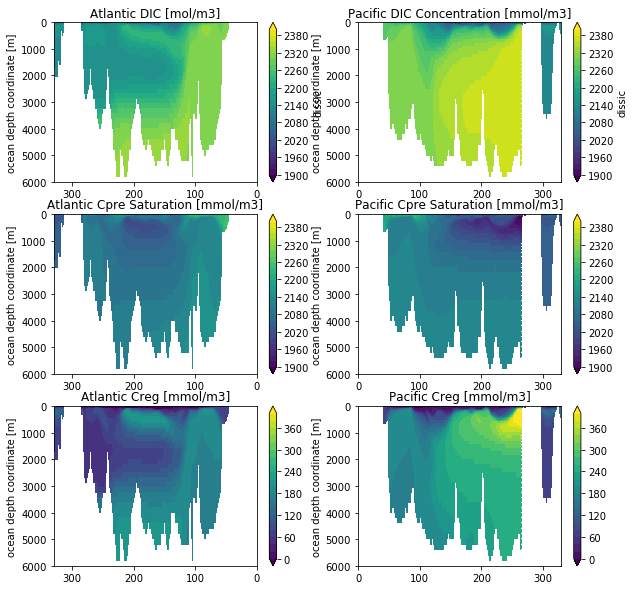

In [90]:
R_co=170/117

cpre=(model.dissic-aou*R_co)*1e3
creg=aou*R_co*1e3

fig, (axes) = plt.subplots(figsize=(10,10),ncols=2,nrows=3)
(model.isel(time=-1).isel(i=255).dissic*1e3).plot(ax=axes[0,0],levels=np.arange(1900,2420,20),cmap='viridis',extend="both")
(model.isel(time=-1).isel(i=125).dissic*1e3).plot(ax=axes[0,1],levels=np.arange(1900,2420,20),cmap='viridis',extend="both")

# Looks like O2sat is 1000x too small! Maybe they doubley applied the mmol->mol conversion?
(cpre.isel(time=-1).isel(i=255)).plot(ax=axes[1,0],levels=np.arange(1900,2420,20),cmap='viridis',extend="both")
(cpre.isel(time=-1).isel(i=125)).plot(ax=axes[1,1],levels=np.arange(1900,2420,20),cmap='viridis',extend="both")

(creg.isel(time=-1).isel(i=255)).plot(ax=axes[2,0],levels=np.arange(0,420,20),cmap='viridis',extend="both")
(creg.isel(time=-1).isel(i=125)).plot(ax=axes[2,1],levels=np.arange(0,420,20),cmap='viridis',extend="both")

for jj in range(0,2):
    for ii in range(0,3):
        if jj==0:
            axes[ii,jj].set_xlim(330,0)
        axes[ii,jj].set_ylim(6000,0)
        axes[ii,jj].set_xlabel("")
        
axes[0,0].set_title("Atlantic DIC [mol/m3]")
axes[0,1].set_title("Pacific DIC Concentration [mmol/m3]")
axes[1,0].set_title("Atlantic Cpre Saturation [mmol/m3]")
axes[1,1].set_title("Pacific Cpre Saturation [mmol/m3]")
axes[2,0].set_title("Atlantic Creg [mmol/m3]")
axes[2,1].set_title("Pacific Creg [mmol/m3]")
plt.show()

In [48]:
# What about models that dont have o2sat? Can calculate using the GSW toolbox
import gsw

gsw_as=xr.apply_ufunc(gsw.SA_from_SP, models.so, models.lev, models.longitude, models.latitude,dask=True)


ValueError: unknown setting for dask array handling in apply_ufunc: True

In [46]:
gsw_ct=xr.apply_ufunc(gsw.CT_from_t, gsw_as, modelt.thetao, modelt.lev)


o2sat=xr.apply_ufunc(gsw.O2sol,gsw_as, gsw_ct, model.lev, models.longitude, models.latitude)


<xarray.DataArray 'lev' (lev: 75)>
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.080303e+02,
       1.200000e+02, 1.330758e+02, 1.474062e+02, 1.631645e+02, 1.805499e+02,
       1.997900e+02, 2.211412e+02, 2.448906e+02, 2.713564e+02, 3.008875e+02,
       3.338628e+02, 3.706885e+02, 4.117939e+02, 4.576256e+02, 5.086399e+02,
       5.652923e+02, 6.280260e+02, 6.972587e+02, 7.733683e+02, 8.566790e+02,
       9.474479e+02, 1.045854e+03, 1.151991e+03, 1.265861e+03, 1.387377e+03,
       1.516364e+03, 1.652568e+03, 1.795671e+03, 1.945296e+03, 2.101027e+03,
       2.262422e+03, 2.429025e+03, 2.600380e+03, 2.776039e+03, 2.955570e+03,
       3.138565e+03, 3.324641e+03, 3.5134